[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

# Sub-graphs

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

We just covered parallelization, which is one important LangGraph controllability topic.

## Goals

Now, we're [going to cover sub-graphs](https://docs.langchain.com/oss/python/langgraph/use-subgraphs).

## State

Sub-graphs allow you to create and manage different states in different parts of your graph.

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

* I have a system that accepts logs
* It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
* I want to perform these two operations in two different sub-graphs.

The most critical thing to understand is how the graphs communicate!

In short, communication is **done with over-lapping keys**:

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## Input

Let's define a schema for the logs that will be input to our graph.

In [1]:
%%capture --no-stderr
%pip install -U  langgraph

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


In [4]:
from typing_extensions import TypedDict
from typing import List, Optional, Annotated
from operator import add




class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]
    status: Optional[str]  # new field to track sub-graph progress or processing stage


## Sub graphs

Here is the failure analysis sub-graph, which uses `FailureAnalysisState`.

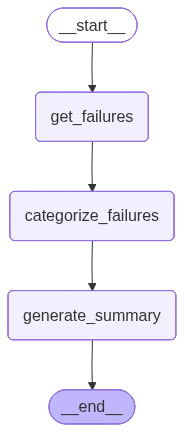

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import List

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    categorized_failures: dict
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """Identify logs that contain a failure."""
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    print(f"Detected {len(failures)} failure logs.")  # For better trace visibility
    return {"failures": failures}

def categorize_failures(state):
    """Categorize failures based on their severity."""
    failures = state["failures"]
    categorized = {"critical": [], "minor": []}
    for f in failures:
        if f.get("grade", 1) == 0:
            categorized["critical"].append(f)
        else:
            categorized["minor"].append(f)
    return {"categorized_failures": categorized}

def generate_summary(state):
    """Generate a brief summary of failure findings."""
    categorized = state["categorized_failures"]
    total_failures = sum(len(v) for v in categorized.values())
    fa_summary = f"{total_failures} total failures found ({len(categorized['critical'])} critical, {len(categorized['minor'])} minor)."
    processed_logs = [f"failure-analysis-on-log-{log['id']}" for group in categorized.values() for log in group]
    return {"fa_summary": fa_summary, "processed_logs": processed_logs}

# Build Failure Analysis sub-graph
fa_builder = StateGraph(state_schema=FailureAnalysisState, output_schema=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("categorize_failures", categorize_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "categorize_failures")
fa_builder.add_edge("categorize_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


Here is the question summarization sub-grap, which uses `QuestionSummarizationState`.

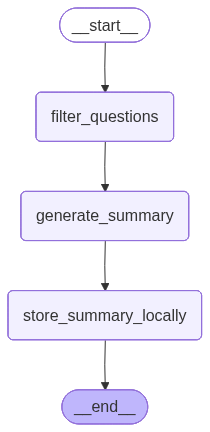

In [6]:
# Summarization Sub-graph
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import List

class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    filtered_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def filter_questions(state):
    """Filter logs that contain valid questions for summarization."""
    cleaned_logs = state["cleaned_logs"]
    filtered = [log for log in cleaned_logs if "question" in log and log["question"]]
    print(f"Filtered {len(filtered)} questions for summarization.")
    return {"filtered_logs": filtered}

def generate_summary(state):
    """Generate a short summary based on filtered questions."""
    filtered_logs = state["filtered_logs"]
    questions = [log["question"] for log in filtered_logs]
    summary = f"Found {len(questions)} key questions: " + ", ".join(questions)
    return {
        "qs_summary": summary,
        "processed_logs": [f"summary-on-log-{log['id']}" for log in filtered_logs],
    }

def store_summary_locally(state):
    """Simulate storing or finalizing the generated summary."""
    qs_summary = state["qs_summary"]
    report = f"Summary stored successfully. Details: {qs_summary[:60]}..."
    print("Summary stored locally for further review.")
    return {"report": report}

# Build Question Summarization Sub-graph
qs_builder = StateGraph(QuestionSummarizationState, output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("filter_questions", filter_questions)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("store_summary_locally", store_summary_locally)
qs_builder.add_edge(START, "filter_questions")
qs_builder.add_edge("filter_questions", "generate_summary")
qs_builder.add_edge("generate_summary", "store_summary_locally")
qs_builder.add_edge("store_summary_locally", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


## Adding sub graphs to our parent graph

Now, we can bring it all together.

We create our parent graph with `EntryGraphState`.

And we add our sub-graphs as nodes!

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

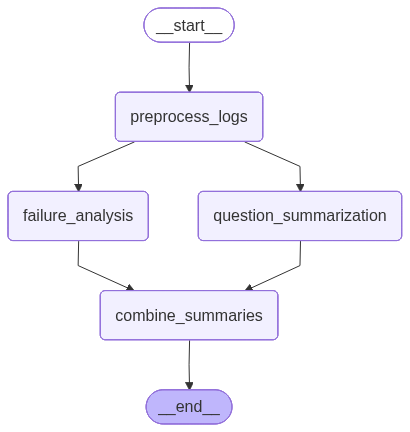

In [11]:
# Entry Graph
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import List, Annotated
from operator import add

class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add]   # shared input for sub-graphs
    fa_summary: str                           # from Failure Analysis sub-graph
    report: str                               # from Question Summarization sub-graph
    combined_summary: str                     # merged output node
    processed_logs: Annotated[List[str], add] # generated by both sub-graphs

def preprocess_logs(state):
    """Clean raw logs before passing to sub-graphs."""
    raw_logs = state["raw_logs"]
    cleaned = [log for log in raw_logs if log.get("question") and log.get("answer")]
    print(f"✅ Preprocessed {len(cleaned)} logs successfully.")
    return {"cleaned_logs": cleaned}

def combine_summaries(state):
    """Combine outputs from both sub-graphs."""
    fa_summary = state.get("fa_summary", "")
    report = state.get("report", "")
    merged = f"Failure Insights: {fa_summary} || Question Insights: {report}"
    print("🔗 Combined results from both sub-graphs.")
    return {"combined_summary": merged}

# Initialize Entry Graph builder
entry_builder = StateGraph(EntryGraphState)

# Add nodes
entry_builder.add_node("preprocess_logs", preprocess_logs)
entry_builder.add_node("failure_analysis", fa_builder.compile())        # ✅ fixed here
entry_builder.add_node("question_summarization", qs_builder.compile())  # ✅ fixed here
entry_builder.add_node("combine_summaries", combine_summaries)

# Define graph flow
entry_builder.add_edge(START, "preprocess_logs")
entry_builder.add_edge("preprocess_logs", "failure_analysis")
entry_builder.add_edge("preprocess_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", "combine_summaries")
entry_builder.add_edge("question_summarization", "combine_summaries")
entry_builder.add_edge("combine_summaries", END)

# Compile Entry Graph
entry_graph = entry_builder.compile()
display(Image(entry_graph.get_graph().draw_mermaid_png()))


But, why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

```
cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified.

The sub-graphs are run in parallel.

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

But, we can work around this by using another concept we talked about before.

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

We don't actually need each sub-graph to output `cleaned_logs`.

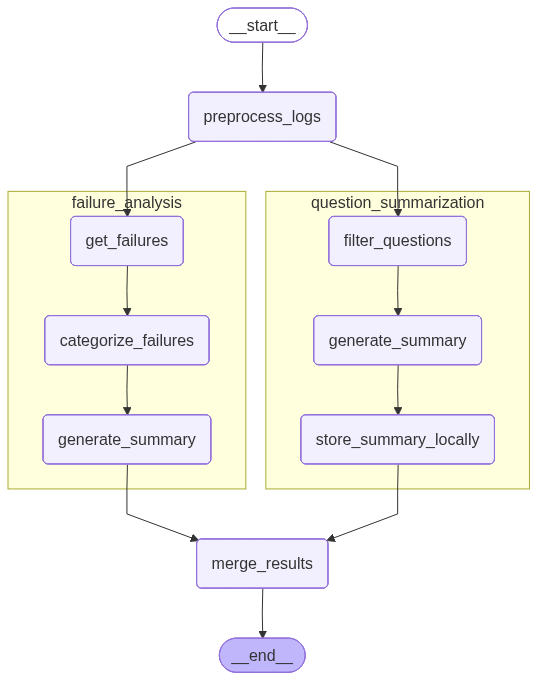

In [12]:
# Entry Graph (Modified Version)
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    failure_summary: str
    qs_report: str
    combined_summary: str
    processed_logs: Annotated[List[str], add]

def preprocess_logs(state):
    raw_logs = state["raw_logs"]
    cleaned = [log for log in raw_logs if log.get("question") and log.get("answer")]
    print(f"✅ Cleaned {len(cleaned)} logs before analysis.")
    return {"cleaned_logs": cleaned}

def merge_results(state):
    merged = f"Failure Summary: {state['failure_summary']} || QS Report: {state['qs_report']}"
    print("🔗 Results merged successfully.")
    return {"combined_summary": merged}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("preprocess_logs", preprocess_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
entry_builder.add_node("merge_results", merge_results)

entry_builder.add_edge(START, "preprocess_logs")
entry_builder.add_edge("preprocess_logs", "failure_analysis")
entry_builder.add_edge("preprocess_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", "merge_results")
entry_builder.add_edge("question_summarization", "merge_results")
entry_builder.add_edge("merge_results", END)

graph = entry_builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [13]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer, question_answer_feedback]

# ✅ Run your compiled entry graph (make sure variable name matches)
result = entry_graph.invoke({"raw_logs": raw_logs})

print("\n📘 Final Output:")
print(result)


✅ Preprocessed 2 logs successfully.
Detected 1 failure logs.
Filtered 2 questions for summarization.
Summary stored locally for further review.
🔗 Combined results from both sub-graphs.

📘 Final Output:
{'raw_logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'grader': 'Document Relevance Recall', 'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}], 'cleaned_logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retr

## LangSmith

Let's look at the LangSmith trace:

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r